In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
df = pd.read_csv("data.csv", parse_dates=True, index_col = "Dates",sep=';')
print(f"Nombre d'échantillons : {len(df)}")
df

Nombre d'échantillons : 6357


,EONIA Index,SXXR Index
Dates,,
1999-01-04,3.200,358.62
1999-01-05,3.200,363.10
1999-01-06,3.210,371.46
1999-01-07,3.210,367.03
1999-01-08,3.210,368.87
...,...,...
2023-05-10,3.145,1086.08
2023-05-11,3.145,1086.85
2023-05-12,3.148,1091.72


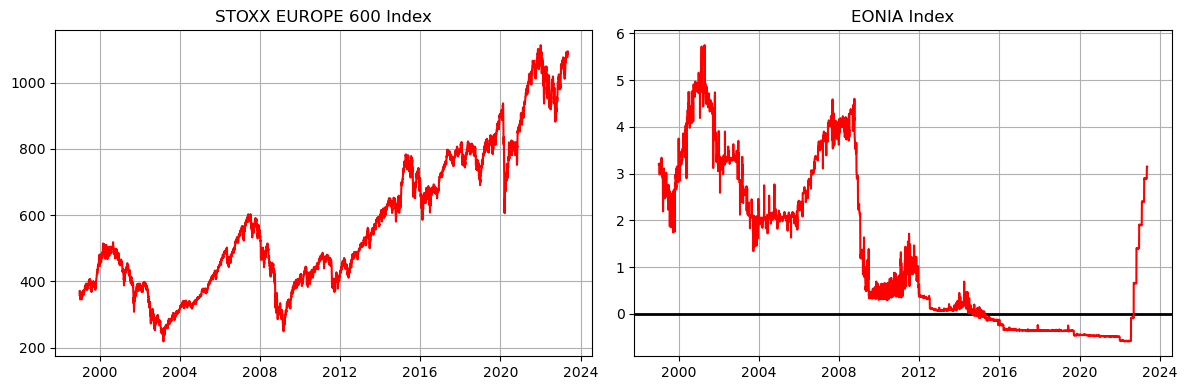

In [4]:
sxxr = pd.DataFrame(df["SXXR Index"])
eonia = pd.DataFrame(df["EONIA Index"])

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr, c="r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(eonia,c="r")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
def interest(df:pd.DataFrame=sxxr, initial:float = 100,year: Union[int,str] = 2000, horizon:int=5, 
             y0:Union[int,str] = 2000,alldata:bool = True)->pd.DataFrame:
    """
    parameters:
        df:The index SXXR
        initial: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """
    if type(y0)==int:
        tabn = df[str(y0-1):str(y0-1)]
        tabn = pd.DataFrame(tabn.iloc[-1]).T
        
    if type(y0)==str:
        y = int(y0[0:4])
        tab = df[y0:str(y+horizon)]
    elif type(y0)==int:
        tab = df[str(y0):str(y0+horizon)] 
        tab = pd.concat([tabn,tab])
    
    n = len(tab)
    S = [x for x in tab["SXXR Index"]]
    rate = []
    S0 = S[0]
    compteur = 0
    for t in S:
        if compteur==0:
            rendement = round((S[compteur]/S0 -1)*100,3)
        else:
            rendement = round((S[compteur]/S[compteur-1] -1)*100,3)
        rate.append(rendement)
        compteur += 1
    tab["Return"] = rate 
    tab = tab.drop("SXXR Index", axis = 1)
    invest = []
    count = 0
    for t in rate:
        if count == 0:
            inv = initial * (1 + t/100)
        else:
            inv = invest[-1] * (1 + t/100)
        count += 1
        invest.append(inv)
    tab["SXXR Index"] = invest
    tab = tab.drop("Return", axis = 1)
    if alldata:
        obj = tab
    else:
        obj = particularyear(tab,year)
    return obj

def monetarize(df:np.ndarray, nav:float, year:Union[int,str] =2000, 
               horizon:int=0,y0:Union[int,str]=2000, alldata:bool=True)->pd.DataFrame:
    """
    parameters:
        df:The index EONIA
        nav: The initial investment
        y0: The year in which the client had begun to invest
        year: The exact year you wish to check how your initial investment fluctuates
        horizon: how long your would like that the investment lasts
        alldata: 
            If true, the function returns all the investment since the beginning
            If false, the function only return the investment at a specific year between y0 and y0+horizon
    return : 
        DataFrame
    """

    
    # Années précédente, à prendre le dernier jour
    if type(y0)==int:
        tab_prec = df[str(y0-1):str(y0-1)]
        tab_prec["Loan"] = 100
        tab_prec = pd.DataFrame(tab_prec.iloc[-1]).T
        # Années en cours sur un horizon donné
        tab_suiv = df[str(y0):str(y0+horizon)]
        tab_suiv["Loan"] = 100
        tab = pd.concat([tab_prec, tab_suiv])
    if type(y0)==str:
        y = int(y0[0:4])
        tab = df[y0:str(y+horizon)]
        tab["Loan"]=100
    
    rate = [x for x in tab.iloc[:,0]]
    table = np.zeros((len(rate)+1,1))
    table[0] = nav
    compteur = 0
    for elem in rate:
        compteur+=1
        table[compteur] = np.round(table[compteur-1] * (1 + elem/(365*100)),5)
    tab["Loan"] = np.round(table[0:-1],3)
    tab = tab.drop("EONIA Index", axis = 1)
    # Year Y
    if type(y0)==int:
        tabl = tab[str(y0):str(y0+horizon)]
        # Year Y-1
        yearn = y0-1
        tabn = tab[str(yearn):str(yearn)]
        yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T
        # Concatenate    
        tabulate = pd.concat([yearn_last_day,tabl])
    elif type(y0)==str:
        tabl = tab[y0:str(y+horizon)]
        tabulate = tabl
    
    tabulate["EONIA Index"] = tabulate
    tabulate = tabulate.drop("Loan", axis = 1)
    if alldata:
        obj = tabulate
    else:
        obj = particularyear(tabulate,year)
    
    return obj

def particularyear(df:pd.DataFrame,year):
    tab = df
    
    # Year Y-1
    yearn = year-1
    tabn = tab[str(yearn):str(yearn)]
    yearn_last_day = pd.DataFrame(tabn.iloc[-1]).T

    # Year Y
    tabl = tab[str(year):str(year)]  
    
    # Concatenate    
    tabulate = pd.concat([yearn_last_day,tabl])
    
    return tabulate 

def concat(df1:pd.DataFrame, df2:pd.DataFrame):
    if all(df1.index == df2.index):
        tab = pd.concat([df1,df2],axis =1 )
    else:
        print("Please, be sure both DataFrame have the same index")
    return tab

def VL(df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia,initial:float=100, weight:float=0.8, year:int=2000, horizon:int=5,y0:int=2000, alldata:bool=True):
    initial_risk = weight * initial
    initial_norisk = (1-weight) * initial
    risk = interest(df1,initial_risk, year,horizon,y0,alldata)
    norisk = monetarize(df2, initial_norisk, year,horizon,y0,alldata)
    tab = concat(risk,norisk)
    tab["VL"] = tab["SXXR Index"] + tab["EONIA Index"]
    tab = pd.DataFrame(tab["VL"])
    return tab

def get_list_protected(df:pd.DataFrame, year:int, plancher:float=0.9, horizon:int=0):
    tabn = df[str(year-1):str(year-1)]
    tabn = pd.DataFrame(tabn.iloc[-1]).T
    tabz = df[str(year):str(year+horizon)]
    tab = pd.concat([tabn, tabz])
    all_plancher = []
    elemlist = []
    for elem in tab.iloc[:,0]:
        elemlist.append(elem)
        if elem == np.max(elemlist):
            planch = plancher * elem
            all_plancher.append(planch)
        else:
            planch = all_plancher[-1]
            all_plancher.append(planch)
            
    #result
    tab["Plancher"] = all_plancher
    tab["Coussin"] = tab["VL"] - tab["Plancher"]
        
    return tab

# Exemple - Représentations Graphiques des indices

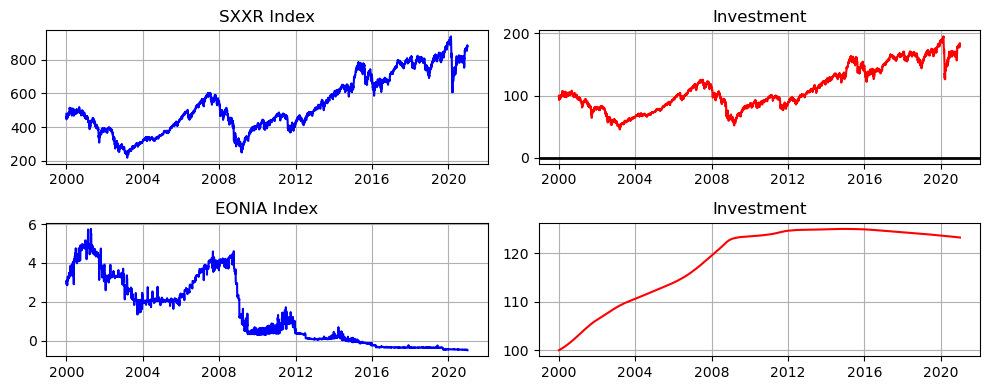

In [7]:
investment = interest(sxxr,100,2001,20,2000)
monnaie = monetarize(eonia, 100, 2001, 20,2000)

# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(sxxr["2000":"2020"], c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(investment["2000":"2020"],c="r")
ax2.set_title('Investment')
ax2.grid(True)

# Tracé des graphiques à gauche
ax3.plot(eonia["2000":"2020"], c="b")
ax3.set_title('EONIA Index')
ax3.grid(True)

ax4.plot(monnaie["2000":"2020"],c="r")
ax4.set_title('Investment')
ax4.grid(True)



# Affichage de la figure
plt.tight_layout()
plt.show()


In [8]:
def volatility(df:pd.DataFrame,msg:bool=False):
    tab = df.copy()
    S = [x for x in tab.iloc[:,0]]
    rendement = []
    for i in range(len(S)):
        if i==0:
            r = 0
        else:
            rt = S[i]
            rtt = S[i-1]
            r = np.log(rt/rtt)
        rendement.append(r)
    m = np.mean(rendement)
    if abs(m)<0.01:
        m = 0
    else:
        m = m
    
    rendement = np.array(rendement).reshape(-1,1)
    moyenne = m*np.ones((len(rendement),1))
    rend = rendement - moyenne
    
    sig2 = float(1/(len(rendement)-1) * (sum((rend)**2)))
    sig = np.sqrt(sig2)
    annualized = sig * np.sqrt(252)
    
    if msg == True:
        print(f"La volatilité de la série s'élève à {round(annualized*100,3)} % ")
    else:
        pass
    
    return annualized

In [9]:
initiale = float(sxxr["2000"].iloc[0,0])
investment = interest(sxxr,initiale,2000,5,2000)
sxxr.describe()

vol = volatility(investment,True)
vol

La volatilité de la série s'élève à 19.397 % 


0.19397350836657687

## CPPI - Un test sur les planchers, sans protection

In [10]:
class CPPI:
    def __init__(self, df1:pd.DataFrame = sxxr, df2:pd.DataFrame = eonia):
        self.df1 = df1
        self.df2 = df2
        
    def liquidative(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):
        df1 = self.df1
        df2 = self.df2
        vl = VL(df1,df2,initial, weight, year, horizon, y0, alldata)
        protec = get_list_protected(vl, year, plancher, horizon)
        
        return protec
    
    def unified(self,initial:float=100, weight:float=0.8, plancher:float = 0.9, year:int=2000, horizon:int=0, y0:int=2000, alldata:bool=True):

        # Year Y
        df_0 = self.liquidative(initial, weight, plancher, year,horizon, y0,False)
        df_0 = df_0.drop(df_0.index[-1])
        # Year Y+1
        df_1 = self.liquidative(initial, weight, plancher, year+1,horizon, y0,False)
        df_1 = df_1.drop(df_1.index[-1])
        # Year Y+2
        df_2 = self.liquidative(initial, weight, plancher, year+2,horizon, y0,False)
        df_2 = df_2.drop(df_2.index[-1])
        # Year Y+3
        df_3 = self.liquidative(initial, weight, plancher, year+3,horizon, y0,False)
        df_3 = df_3.drop(df_3.index[-1])
        # Year Y+4 (Final)
        df_4 = self.liquidative(initial, weight, plancher, year+4,horizon, y0,False)
        
        # Concat :
        df = pd.concat([df_0,df_1,df_2,df_3,df_4],axis=0)
        return df

<AxesSubplot:>

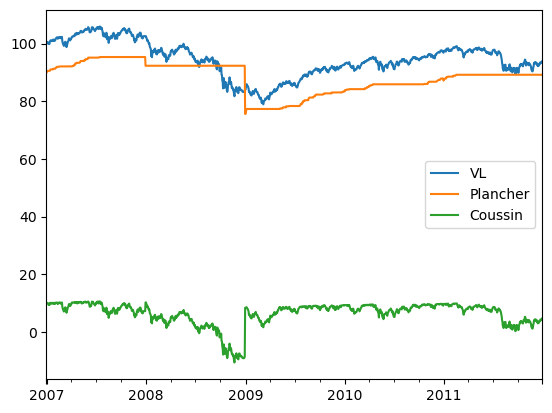

In [11]:
a = CPPI()
b = a.liquidative(100,0.45,0.9,2007,5,2007,False)
c = a.unified(100,0.45,0.9,2007,5,2007,False)
c.plot()

# CPPI - Avec protection

In [12]:
def reajust_date(df:pd.DataFrame)->str:
    tab = df
    n = len(tab)
    coussin = pd.DataFrame(tab["Coussin"])
    coussin["Rang"] = range(n)
    couss = [round(x,4) for x in coussin["Coussin"]]
    
    negcouss = []
    date = []
    count = 0
    if min(couss) <= 0:
        for c in coussin["Coussin"]:
            if c <= 0:
                negcouss.append(count)
                dateJ = coussin.iloc[count:count+1].index[0]
                date.append(dateJ)
            count += 1
    else:
        count = len(coussin)-1
        negcouss.append(count) #The last index
        dateJ = coussin.iloc[count:count+1].index[0]
        date.append(dateJ)
        
    location_index = negcouss[0]
    location_date = date[0]
    
    return location_date, location_index

investment = interest(sxxr,100,2001,20,2000)
monnaie = monetarize(eonia, 100, 2001, 20,2000)

def reajust(df:pd.DataFrame, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia, year:int=2000, y0:int=2000, horizon:int=5,initial:float =100, weight:float = 0.8,alldata:bool=True):
    tab = df
    risk_invest = initial * weight
    norisk_invest = initial * (1-weight)
    investment = interest(df1,risk_invest,year,horizon,y0,alldata)
    monnaie = monetarize(df2, norisk_invest,year,horizon,y0,alldata)
    indexes = concat(investment,monnaie)
    tabulate = concat(tab, indexes)
    date_couss_negative = reajust_date(df)[0]
    data= pd.DataFrame(tabulate.loc[date_couss_negative:str(year)])
    eonia = df2.loc[date_couss_negative:str(year)]
    allocation = data[["SXXR Index", "EONIA Index"]]
    allocation["EONIA"] = eonia
    allocation["EONIA Index"] = allocation["SXXR Index"] + allocation["EONIA Index"]
    allocation["SXXR Index"] = 0
    rate = [x for x in allocation["EONIA"]]
    val = []
    nb = len(allocation)
    count = 0
    index_couss_negative = reajust_date(df)[1]
    if index_couss_negative != len(df)-1:
        for r in rate:
            if count == 0:
                value = allocation.iloc[count,1]
            else:
                value = val[count-1] * (1+r/(365*100))
            count += 1 
            val.append(value)
        allocation['VL'] = val
        before = pd.DataFrame(tabulate["VL"].iloc[0:index_couss_negative,])
        after = pd.DataFrame(allocation["VL"])
        result = pd.concat([before,after],axis=0)
    else:
        result = pd.DataFrame(tabulate["VL"])
    return result



In [13]:
class FinalCPPI:
    def __init__(self, df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia):
        self.df1 = df1
        self.df2 = df2
        
        self.fees = 0.01
        self.all_fees = []
        
    def finalprotection(self,initial = 100, weight=0.8, year=2000, horizon=5,y0=2000, alldata=False,plancher=0.9,h=5):
        df1 = self.df1
        df2 = self.df2
        
        liste = []
        lastval = initial * (1-self.fees)
        self.all_fees.append(initial*self.fees)
        for i in range(h):
            val = VL(df1,df2,lastval,weight,year+i,horizon,y0+i,alldata)
            protect_priori = get_list_protected(val, year+i,plancher,0)
            ajustement = reajust(protect_priori,df1,df2,year+i,y0+i,horizon,lastval,weight,alldata)
            protect_posteriori = get_list_protected(ajustement, year+i, plancher, 0)
            if i != max(range(5)):
                protect_posteriori = protect_posteriori.drop(protect_posteriori.index[-1])
            lastval = protect_posteriori.iloc[-1,0] * (1-self.fees)
            self.all_fees.append(protect_posteriori.iloc[-1,0] * self.fees)
            liste.append(protect_posteriori)
        
        df = pd.concat(liste,axis=0)
        return df

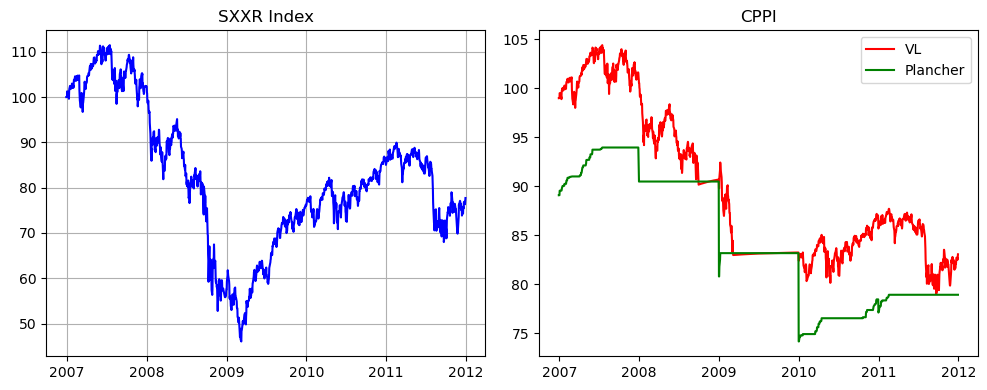

In [14]:
cppi2007 = FinalCPPI()
protection2007 = cppi2007.finalprotection(100,0.4,2007,10,2007,False,0.9,5)
investment2007 = interest(sxxr,100,2007,4,2007)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2007, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2007["VL"], c="r",label="VL")
ax2.plot(protection2007["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
allfees = cppi2007.all_fees
allfees

[1.0,
 1.0156295149829242,
 0.9069814723303223,
 0.832600239835654,
 0.8657107623783968,
 0.8307543816745826]

In [16]:
# Volatilité 

df2007 = pd.DataFrame(protection2007["VL"])
vol2007 = volatility(df2007)
volsxxr2007 = volatility(sxxr["2007":"2011"])

# Crise 2008

sxxr2008 = sxxr["2008"]
sxxrjan2008 = sxxr2008.iloc[0,0]
sxxrdec2008 = sxxr2008.iloc[-1,0]
print(f"Sur l'année 2008, l'indice a baissé de {round(abs(sxxrdec2008/sxxrjan2008 -1)*100,3)}%, \
passant de {round(sxxrjan2008,2)}€ à {round(sxxrdec2008,2)}€ ")

Sur l'année 2008, l'indice a baissé de 43.769%, passant de 553.54€ à 311.26€ 


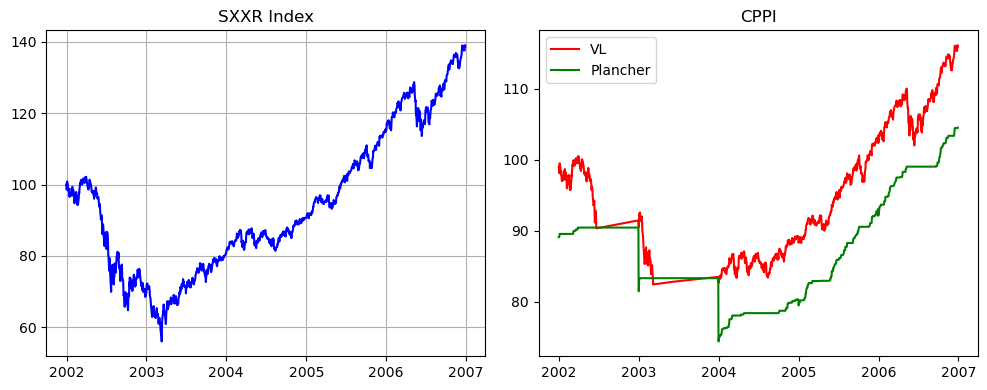

In [17]:
cppi2002 = FinalCPPI()
protection2002 = cppi2002.finalprotection(100,0.6,2002,10,2002,False,0.9,5)
investment2002 = interest(sxxr,100,2002,4,2002)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2002, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2002["VL"], c="r",label="VL")
ax2.plot(protection2002["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
protection2002

,VL,Plancher,Coussin
2001-12-31,99.000000,89.100000,9.900000
2002-01-01,99.004000,89.103600,9.900400
2002-01-02,98.124722,89.103600,9.021122
2002-01-03,99.205430,89.284887,9.920543
2002-01-04,99.506205,89.555584,9.950620
...,...,...,...
2006-12-25,115.348717,104.464986,10.883731
2006-12-26,115.352717,104.464986,10.887731
2006-12-27,116.123112,104.510801,11.612311
2006-12-28,116.157600,104.541840,11.615760


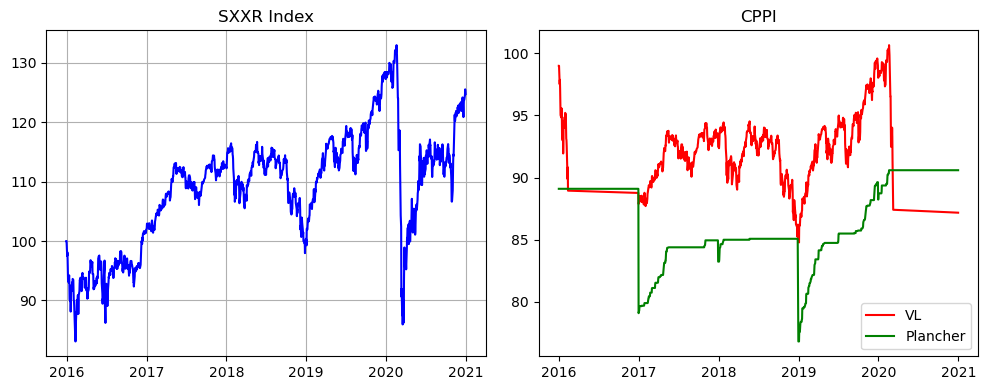

In [19]:
cppi2016 = FinalCPPI()
protection2016 = cppi2016.finalprotection(100,0.6,2016,10,2016,False,0.9,5)
investment2016 = interest(sxxr,100,2016,4,2016)
# Création de la figure et des sous-graphiques
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(investment2016, c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

#ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(protection2016["VL"], c="r",label="VL")
ax2.plot(protection2016["Plancher"], c="g", label="Plancher")
ax2.set_title('CPPI')

# Affichage de la figure
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
class Statistic:
    def __init__(self, df:pd.DataFrame, df1:pd.DataFrame=sxxr,df2:pd.DataFrame=eonia):
        self.df = df.copy()
        self.df1 = df1.copy()
        self.df2 = df2.copy()
        if "VL" in self.df:
            pass
        else:
            print("ERROR ! Le tableau VL n'existe pas")
        self.tab = pd.DataFrame(self.df["VL"])
        
        
    def moyenne(self, msg:bool=False):
        moy = float(np.mean(self.tab))
        if msg==True:
            print(f"La valeur liquidative moyenne s'élève à : {moy}")
        else:
            pass
        return moy
    
    def annualized_volatility(self,msg:bool = False):
        vol = float(volatility(self.tab,False))
        if msg == True:
            print(f"La volatilité de la série s'élève à {round(vol*100,3)} % ")
        else:
            pass
        return vol
    
    def ratiosharpe(self, msg:bool=False):
        tab =  pd.DataFrame(self.df["VL"])
        rdmt_ann = self.rendement_annualise(False)
        
        eon = [x/100 for x in self.df2.iloc[:,0]]
        eon_mean = np.mean(eon)
        
        vol = volatility(tab)
        
        sharpe = (rdmt_ann-eon_mean)/vol
        
        if msg == True:
            print(f"Le ratio de sharpe est à hauteur de {round(sharpe,2)}")
        
        return sharpe
    
    def drawdown(self, msg:bool=False,comparaison:bool=False):
        tab = pd.DataFrame(self.df["VL"]).copy()
        tab["DrawDown"] = 0
        n = len(tab)
        vl = [x for x in tab.iloc[:,0]]
        DD = []
        for i in range(len(vl)):
            if i < len(vl)-1:
                current = vl[i]
                draw = (min(vl[i+1:])/current)-1
                DD.append(draw)
        maxdraw = min(DD)

        themax_index = DD.index(maxdraw)
        
        
        if msg==True:
            print(f"Le max drawdown du Fonds est de : {round(maxdraw*100,2)}%")
            pass
        else:
            pass
        
        if comparaison==True:
            debut = str(tab.index[1])[0:4]
            fin = str(tab.index[-1])[0:4]
            tab1 = self.df1[debut:fin].copy()
            ind = [x for x in tab1.iloc[:,0]]
            DDsxxr = []
            for i in range(len(tab1)):
                if i < len(tab1)-1:
                    currentsxxr = ind[i]
                    drawsxxr = (min(ind[i+1:])/currentsxxr)-1
                    DDsxxr.append(drawsxxr)
            maxdrawsxxr = min(DDsxxr)
            print(f"Le max drawdown de l'indice SXXR est de : {round(maxdrawsxxr*100,2)}%")
        
        return pd.DataFrame(tab.iloc[themax_index:,0])
    
    def skewness(self,msg:bool = False):
        tab = pd.DataFrame(self.df["VL"])
        mean = self.moyenne(False)
        vl = [x for x in tab.iloc[:,0]]
        std = np.std(vl)
        tab["For skew"] = ((tab["VL"]-mean)/std)**3
        allskew = [x for x in tab.iloc[:,1]]
        
        skew = np.mean(allskew)
        
        if msg==True:
            print(f"Le skewness de la série est de : {round(skew,2)}")
        else:
            pass
        
        return skew
    
    def rendement_annualise(self, msg:bool=False):
        tab = pd.DataFrame(self.df["VL"])
        initiale = float(tab.iloc[0,0]) 
        finale = float(tab.iloc[-1,0])
        year_initiale = int(str(tab.iloc[0:,0].index[0])[0:4])
        year_finale = int(str(tab.iloc[0:,0].index[-1])[0:4])
        nb_year = year_finale-year_initiale
        rendement_ann = (finale/initiale)**(1/nb_year) -1
        
        if msg == True:
            print(f"Sur une période de 5 ans, le Fonds a généré un rendement annualisé de {round(rendement_ann*100,2)}%")
        
        return rendement_ann
    
    def allstat(self)->None:
        moy = self.moyenne(True)
        annvol = self.annualized_volatility(True)
        sharpe = self.ratiosharpe(True)
        draw = self.drawdown(True,True)
        skew = self.skewness(True)
        annrend = self.rendement_annualise(True)
        return None


In [21]:
# Période 2002-2007
stat2002  = Statistic(protection2002)
data2002 = stat2002.allstat()

La valeur liquidative moyenne s'élève à : 93.46839926781699
La volatilité de la série s'élève à 6.659 % 
Le ratio de sharpe est à hauteur de 0.28
Le max drawdown du Fonds est de : -17.97%
Le max drawdown de l'indice SXXR est de : -45.18%
Le skewness de la série est de : 0.66
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de 3.21%


In [22]:
# Période 2007-2012
stat2007  = Statistic(protection2007)
vol2007 = volatility(sxxr["2007":"2011"])
data2007 = stat2007.allstat()
vol2007

La valeur liquidative moyenne s'élève à : 89.55054277169488
La volatilité de la série s'élève à 7.175 % 
Le ratio de sharpe est à hauteur de -0.67
Le max drawdown du Fonds est de : -24.27%
Le max drawdown de l'indice SXXR est de : -58.69%
Le skewness de la série est de : 0.64
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de -3.45%


0.2429903569425011

In [23]:
# Période 2016-2021
stat2016 = Statistic(protection2016)
data2016 = stat2016.allstat()

La valeur liquidative moyenne s'élève à : 91.04163876683828
La volatilité de la série s'élève à 6.527 % 
Le ratio de sharpe est à hauteur de -0.59
Le max drawdown du Fonds est de : -14.36%
Le max drawdown de l'indice SXXR est de : -35.36%
Le skewness de la série est de : 0.65
Sur une période de 5 ans, le Fonds a généré un rendement annualisé de -2.51%


In [73]:
def everydata(df:pd.DataFrame,df1:pd.DataFrame=sxxr, df2:pd.DataFrame=eonia):
    table = pd.DataFrame(df["VL"].copy())
    year_begin = int(str(table.index[1])[0:4])
    year_end = int(str(table.index[-1])[0:4])
    begin_weight_risk = 100
    begin_weight_norisk = 100
    df1 = df1.copy()
    df2 = df2.copy()
    nb_year = year_end - year_begin
    risk = interest(df1, begin_weight_risk,year_begin,nb_year,year_begin,True)
    norisk = monetarize(df2,begin_weight_norisk,year_begin,nb_year,year_begin,True)
    alldata = pd.concat([table,risk,norisk],axis = 1)
    
    return alldata



In [74]:
pro2016 = everydata(protection2016)
pro2007 = everydata(protection2007)
pro2002 = everydata(protection2002)

,VL,SXXR Index,EONIA Index
2015-12-31,99.000000,100.000000,100.000
2016-01-01,99.000000,100.000000,100.000
2016-01-04,97.515594,97.501000,99.999
2016-01-05,97.874250,98.106481,99.999
2016-01-06,97.138816,96.868377,99.998
...,...,...,...
2020-12-25,87.181720,123.787647,98.663
2020-12-28,87.180602,124.599694,98.662
2020-12-29,87.179475,125.547898,98.661
2020-12-30,87.178352,125.127312,98.659
